# Import Packages

In [53]:
import os
from glob import glob
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import tqdm
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score
import torch.functional as F

# Dataset
## define dataset

In [54]:
class ImageDataset(Dataset):
    def __init__(self, data_dir, transform=None, train=True):
        self.data_dir = data_dir
        self.transform = transform
        self.train = train
        self.data_list = os.listdir(self.data_dir)
        self.channel = 1259
        self.data_indices = [
            (data_index, channel_index)
            for data_index in range(len(self.data_list))
            for channel_index in range(self.channel)
        ]

    def __len__(self):
        return len(self.data_indices)

    def __getitem__(self, index):
        data_index, channel_index = self.data_indices[index]
        data_path = os.path.join(self.data_dir, self.data_list[data_index])
        cube = np.load(glob(os.path.join(data_path, 'seismicCubes_RFC_fullstack*'))[0])
        image = cube[:, :, channel_index]
        if self.train:
            maskcube = np.load(glob(os.path.join(data_path, 'fault_segments*'))[0])
            mask = maskcube[:, :, channel_index]
            return image, mask
        else:
            return image


class CubeDataset(Dataset):
    def __init__(self, data_dir, transform=None, train=True):
        self.data_dir = data_dir
        self.transform = transform
        self.train = train
        self.data_list = os.listdir(self.data_dir)

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, index):
        data_path = os.path.join(self.data_dir, self.data_list[index])
        cube = np.load(glob(os.path.join(data_path, 'seismicCubes_RFC_fullstack*'))[0])
        if self.train:
            maskcube = np.load(glob(os.path.join(data_path, 'fault_segments*'))[0])
            return cube, maskcube
        else:
            return cube

## initialize dataset

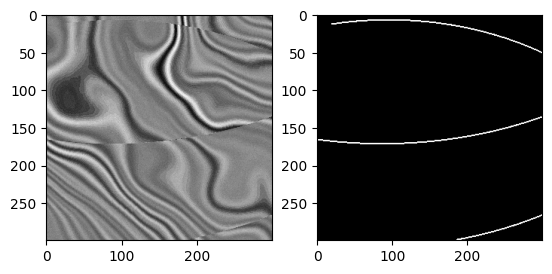

In [55]:
train_dataset_dir = "data"
test_dataset_dir = "data"
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),
                                      transforms.RandomRotation(30),
                                      transforms.ToTensor()])
test_transform = transforms.Compose([transforms.ToTensor()])
full_train_dataset = ImageDataset(train_dataset_dir, train=True)
test_dataset = CubeDataset(test_dataset_dir, test_transform, train=False)

image, mask = full_train_dataset[500]
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.show()

train_dataset, val_dataset = random_split(full_train_dataset, [0.8, 0.2])
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = test_transform

## initialize dataloader

In [58]:
batch_size = 16
class_num = 2
train_loader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4)

print(batch_size)
print(f'Train dataset size:{len(train_loader)} images batches')
print(f'Validation dataset size:{len(val_loader)} images batches')
print(f'Test dataset size:{len(test_loader)} cubes')

16
Train dataset size:126 images batches
Validation dataset size:32 images batches
Test dataset size:2 cubes


# Functions
## loss function

In [ ]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, preds, targets):
        preds = torch.softmax(preds, dim=1)
        num_classes = preds.size(1)
        targets_one_hot = torch.eye(num_classes)[targets.squeeze(1).long().cpu()].to(preds.device)
        targets_one_hot = targets_one_hot.permute(0, 3, 1, 2).float()

        preds_flat = preds.contiguous().view(-1)
        targets_flat = targets_one_hot.contiguous().view(-1)

        intersection = (preds_flat * targets_flat).sum()
        dice_score = (2. * intersection + self.smooth) / (preds_flat.sum() + targets_flat.sum() + self.smooth)
        return 1 - dice_score

## evaluation functions

In [ ]:
def calculate_f1(pred, target, num_classes):
    pred_flat = pred.view(-1).cpu().numpy()
    target_flat = target.view(-1).cpu().numpy()
    # print('t',np.unique(target_flat))
    # print('p',np.unique(pred_flat))
    return f1_score(target_flat, pred_flat, average='macro')


def calculate_miou(pred, target, num_classes):
    ious = []
    pred = torch.argmax(pred, dim=1)
    for cls in range(num_classes):
        pred_inds = pred == cls
        target_inds = target == cls
        intersection = torch.sum(pred_inds & target_inds).item()
        union = torch.sum(pred_inds | target_inds).item()
        if union == 0:
            ious.append(float('nan'))
        else:
            ious.append(intersection / union)
    return np.nanmean(ious)

# Model
## set device


In [52]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device : {device}')

Device : cpu


## load model

## model information

# Training
## initialize parameters

In [50]:
EPOCHS = 10
LR = 1e-5

criterion = DiceLoss
params = model.parameters()
optimizer = torch.optim.AdamW(params, lr=LR)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
model_path = "model"

train_losses = []
train_mious = []
val_F1s = []
val_mious = []

## start training

In [ ]:
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    running_miou = 0.0

    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{EPOCHS}", unit="batch")

    for images, targets in train_loader_tqdm:
        images = images.to(device)
        targets = targets.to(device)
        # print(np.unique(targets))

        optimizer.zero_grad()
        outputs = model(images)
        soft_pro = F.softmax(outputs, dim=1)
        # loss = criterion(outputs, targets.long())
        loss = criterion(soft_pro, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_miou += calculate_miou(outputs, targets, class_num)

        train_loader_tqdm.set_postfix(
            {"Loss": f"{loss:.4f}", "MIOU": f"{(running_miou / (train_loader_tqdm.n + 1)):.4f}"})

    epoch_loss = running_loss / len(train_loader)
    epoch_miou = running_miou / len(train_loader)
    train_losses.append(epoch_loss)
    train_mious.append(epoch_miou)
    print(f'Training Loss: {epoch_loss:.4f}, MIOU: {epoch_miou:.4f}')

    model.eval()
    val_running_miou = 0.0
    val_running_f1 = 0.0
    val_loader_tqdm = tqdm(val_loader, desc=f"Epoch {epoch + 1}/{EPOCHS}", unit="batch")
    with torch.no_grad():
        for val_images, val_targets in val_loader_tqdm:
            val_images = val_images.to(device)
            val_targets = val_targets.to(device)

            val_outputs = model(val_images)
            val_preds = torch.argmax(val_outputs, dim=1)
            val_running_miou += calculate_miou(val_outputs, val_targets, class_num)
            val_running_f1 += calculate_f1(val_preds, val_targets, class_num)
            # print(val_preds.shape, val_targets.shape)
            val_loader_tqdm.set_postfix(
                {"MIOU": f"{(val_running_miou / (val_loader_tqdm.n + 1)):.4f}",
                 "F1": f"{(val_running_f1 / (val_loader_tqdm.n + 1)):.4f}"})

    val_epoch_miou = val_running_miou / len(val_loader)
    val_epoch_f1 = val_running_f1 / len(val_loader)
    val_mious.append(val_epoch_miou)
    val_F1s.append(val_epoch_f1)
    print(
        f'Validation MIOU: {val_epoch_miou:.4f},F1-score: {val_epoch_f1:.4f}')

    torch.save(model.state_dict(), f'{model_path}/epoch{epoch}.pth')
    print('model saved')

# Result

In [50]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.subplot(2, 2, 2)
plt.plot(train_mious)
plt.title('Training MIOU')
plt.subplot(2, 2, 3)
plt.plot(val_mious)
plt.title('Validation MIOU')
plt.subplot(2, 2, 4)
plt.plot(val_F1s)
plt.title('Validation F1')
plt.show()

# Testing